# Objective
* 20191002: 
    * Given prices for the last N days, we do prediction for the next N+H days, where H is the forecast horizon
    * Using xgboost
* 20191004 - Diff from StockPricePrediction_v6_xgboost.ipynb:
    * Instead of using mean and std from train set to do scaling/unscaling, use mean and std from the last N days to do scaling/unscaling
* 20191007 - Diff from StockPricePrediction_v6a_xgboost.ipynb:
    * Include a validation set to do hyperparameter tuning

In [232]:
import chart_studio.plotly as py
import math
import matplotlib
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import time

from collections import defaultdict
from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

# py.sign_in('<your-user-id>', '<your-api-key>') # sign in to plotly if you haven't done so

#### Input params ##################
folder = "./data/"
filename = "VTI_20130102_20181231.csv"

# Predicting on day 1008, date 2017-01-03 00:00:00
# Predicting on day 1050, date 2017-03-06 00:00:00
# Predicting on day 1092, date 2017-05-04 00:00:00
# Predicting on day 1134, date 2017-07-05 00:00:00
# Predicting on day 1176, date 2017-09-01 00:00:00
# Predicting on day 1218, date 2017-11-01 00:00:00
# Predicting on day 1260, date 2018-01-03 00:00:00
# Predicting on day 1302, date 2018-03-06 00:00:00
# Predicting on day 1344, date 2018-05-04 00:00:00
# Predicting on day 1386, date 2018-07-05 00:00:00
# Predicting on day 1428, date 2018-09-04 00:00:00
# Predicting on day 1470, date 2018-11-01 00:00:00

pred_day = 1260                # Predict for this day, for the next H-1 days. Note indexing of days start from 0.

H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                 # Use 1 year of data as validation set

N = 3                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

# Plotly colors
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


# Common functions

In [233]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

In [234]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def pred_xgboost(model, series, N, H):
    """
    Do recursive forecasting using xgboost
    Inputs
        model : the xgboost model
        series: numpy array of shape (len(series),). The time series we want to do recursive forecasting on
        N     : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H     : forecast horizon
    Outputs
        Times series of predictions. Numpy array of shape (H,).
    """
    forecast = series.copy()
    for n in range(H):
        est = model.predict(forecast[-N:].reshape(1,-1))
        forecast = np.append(forecast, est)

    return forecast[-H:]

def unscale_test_est(scaled, prev_vals, prev_mean_val, prev_std_val):
    """
    Given a scaled series, unscale it
    Inputs
        scaled         : numpy array. The scaled series
        prev_vals      : numpy array. If scaled[0] is at time t, prev_vals will contain the N-1 unscaled values at t-1, t-2, ...
        prev_mean_val  : the mean of the unscaled values at t-1, t-2, ..., t-N
        prev_std_val   : the std deviation of the unscaled values at t-1, t-2, ..., t-N
    Outputs
        unscaled values of same length as scaled
    """
    unscaled = np.concatenate([prev_vals, np.array((scaled[0] * prev_std_val) + prev_mean_val).reshape(1,)])
    N = prev_vals.shape[0] + 1
    
    for i in range(1, len(scaled)):
        mean_val = np.mean(unscaled[-N:])
        std_val = np.std(unscaled[-N:])
        unscaled = np.concatenate([unscaled, np.array(scaled[i] * std_val + mean_val).reshape(1,)])
        
    return np.array(unscaled[prev_vals.shape[0]:])

def train_pred_eval_model(X_train_scaled,
                          y_train_scaled,
                          y_test,
                          N,
                          H,
                          prev_vals,
                          prev_mean_val,
                          prev_std_val,
                          seed=100,
                          n_estimators=100,
                          max_depth=3,
                          learning_rate=0.1,
                          min_child_weight=1,
                          subsample=1,
                          colsample_bytree=1,
                          colsample_bylevel=1,
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_vals          : numpy array. If scaled[0] is at time t, prev_vals will contain the N-1 unscaled values at t-1, t-2, ...
        prev_mean_val      : the mean of the unscaled values at t-1, t-2, ..., t-N
        prev_std_val       : the std deviation of the unscaled values at t-1, t-2, ..., t-N
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        mae                : mean absolute error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(objective ='reg:squarederror',
                         seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
        
    # Train the model
    model.fit(X_train_scaled.to_numpy(), y_train_scaled.to_numpy())
    
    # Get predicted labels and scale back to original range
    est_scaled = pred_xgboost(model, y_train_scaled.to_numpy(), N, H)

    est = unscale_test_est(est_scaled, 
                           prev_vals, 
                           prev_mean_val, 
                           prev_std_val)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_test, est)
    mape = get_mape(y_test, est)
    mae = get_mae(y_test, est)
    
    return rmse, mape, mae, est, model.feature_importances_

def add_lags(df, N):
    """
    Add lags up to N number of days to use as features
    The lag columns are labelled as 'adj_close_scaled_lag_1', 'adj_close_scaled_lag_2', ... etc.
    """
    # Use lags up to N number of days to use as features
    df['order_day'] = [x for x in list(range(len(df)))] # Add a column 'order_day' to indicate the order of the rows by date
    merging_keys = ['order_day'] # merging_keys
    lag_cols = ['adj_close_scaled'] # List of columns that we will use to create lags
    shift_range = [x+1 for x in range(N)]
    for shift in shift_range:
        train_shift = df[merging_keys + lag_cols].copy()
    
        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift
    
        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    del train_shift
    
    return df

def get_error_metrics(df,
                      train_size,
                      N,
                      H,
                      seed=100,
                      n_estimators=100,
                      max_depth=3,
                      learning_rate=0.1,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      gamma=0):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                 : train + val dataframe. len(df) = train_size + val_size
        train_size         : size of train set
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        mean of rmse, mean of mape, mean of mae, dictionary of predictions
    """
    rmse_list = [] # root mean square error
    mape_list = [] # mean absolute percentage error
    mae_list = []  # mean absolute error
    preds_dict = {}
    
    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    df = get_mov_avg_std(df, 'adj_close', N)
    
    # Do scaling
    df.loc[:, 'adj_close_scaled'] = (df['adj_close'] - df['adj_close_mean']) / df['adj_close_std']
    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N)
    
    # Get list of features
    features = []
    for n in range(1,N+1):
        features.append("adj_close_scaled_lag_"+str(n))
    
    for i in range(train_size, len(df)-H+1, int(H/2)):
        # Split into train and test
        train = df[i-train_size:i].copy()
        test = df[i:i+H].copy()
    
        # Drop the NaNs in train
        train.dropna(axis=0, how='any', inplace=True)
    
        # Split into X and y
        X_train = train[features]
        y_train = train['adj_close_scaled']
            
        rmse, mape, mae, est, _ = train_pred_eval_model(X_train,
                                                        y_train,
                                                        test['adj_close'],
                                                        N,
                                                        H,
                                                        train[-N+1:]['adj_close'].to_numpy(),
                                                        test.iloc[0]['adj_close_mean'],
                                                        test.iloc[0]['adj_close_std'],
                                                        seed=seed,
                                                        n_estimators=n_estimators,
                                                        max_depth=max_depth,
                                                        learning_rate=learning_rate,
                                                        min_child_weight=min_child_weight,
                                                        subsample=subsample,
                                                        colsample_bytree=colsample_bytree,
                                                        colsample_bylevel=colsample_bylevel,
                                                        gamma=gamma)
#         print("N = " + str(N) + ", i = " + str(i) + ", rmse = " + str(rmse) + ", mape = " + str(mape) + ", mae = " + str(mae))
        
        rmse_list.append(rmse)
        mape_list.append(mape)
        mae_list.append(mae)
        preds_dict[i] = est
    
    return np.mean(rmse_list), np.mean(mape_list), np.mean(mae_list), preds_dict 

def get_error_metrics_one_pred(df,
                               train_size,
                               N,
                               H,
                               seed=100,
                               n_estimators=100,
                               max_depth=3,
                               learning_rate=0.1,
                               min_child_weight=1,
                               subsample=1,
                               colsample_bytree=1,
                               colsample_bylevel=1,
                               gamma=0):
    """
    Given a series consisting of both train+test, do one prediction of forecast horizon H on the test set.
    Inputs
        df                 : train + test dataframe. len(df) = train_size + test_size
        train_size         : size of train set
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        rmse, mape, mae, predictions
    """
    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    df = get_mov_avg_std(df, 'adj_close', N)
    
    # Do scaling
    df.loc[:, 'adj_close_scaled'] = (df['adj_close'] - df['adj_close_mean']) / df['adj_close_std']
    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N)
    
    # Get list of features
    features = []
    for n in range(1,N+1):
        features.append("adj_close_scaled_lag_"+str(n))
    
    # Split into train and test
    train = df[:train_size].copy()
    test = df[train_size:train_size+H].copy()
    
    # Drop the NaNs in train
    train.dropna(axis=0, how='any', inplace=True)
    
    # Split into X and y
    X_train = train[features]
    y_train = train['adj_close_scaled']
            
    rmse, mape, mae, est, feature_importances = train_pred_eval_model(X_train,
                                                                      y_train,
                                                                      test['adj_close'],
                                                                      N,
                                                                      H,
                                                                      train[-N+1:]['adj_close'].to_numpy(),
                                                                      test.iloc[0]['adj_close_mean'],
                                                                      test.iloc[0]['adj_close_std'],
                                                                      seed=seed,
                                                                      n_estimators=n_estimators,
                                                                      max_depth=max_depth,
                                                                      learning_rate=learning_rate,
                                                                      min_child_weight=min_child_weight,
                                                                      subsample=subsample,
                                                                      colsample_bytree=colsample_bytree,
                                                                      colsample_bylevel=colsample_bylevel,
                                                                      gamma=gamma)
    
    return rmse, mape, mae, est, feature_importances, features

# Load data

In [235]:
df = pd.read_csv(folder+filename, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2013-01-02,74.529999,75.150002,74.500000,75.139999,66.997757,5037200,1
1,2013-01-03,75.120003,75.370003,74.839996,75.029999,66.899689,2634600,1
2,2013-01-04,75.139999,75.519997,74.989998,75.410004,67.238510,2512900,1
3,2013-01-07,75.180000,75.279999,74.949997,75.209999,67.060173,2511200,1
4,2013-01-08,75.110001,75.180000,74.699997,75.010002,66.881859,1407900,1


In [236]:
# Remove columns which you can't use as features
df.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

In [237]:
# Plot with plotly
data = [go.Scatter(
            x = df['date'],
            y = df['adj_close'],
            mode = 'lines')]

layout = dict(xaxis = dict(title = 'date'),
              yaxis = dict(title = 'USD'))

fig = dict(data=data, layout=layout)
py.iplot(fig, filename=filename)

# Split into train, validation, test

In [238]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'], H))

Predicting on day 1260, date 2018-01-03 00:00:00, with forecast horizon H = 21


In [239]:
train = df[pred_day-train_val_size:pred_day-val_size].copy()
val = df[pred_day-val_size:pred_day].copy()
train_val = df[pred_day-train_val_size:pred_day].copy()
test = df[pred_day:pred_day+H].copy()
print("train.shape = " + str(train.shape))
print("val.shape = " + str(val.shape))
print("train_val.shape = " + str(train_val.shape))
print("test.shape = " + str(test.shape))

train.shape = (756, 3)
val.shape = (252, 3)
train_val.shape = (1008, 3)
test.shape = (21, 3)


# Predict for a specific H (forecast horizon) and a specific date

In [240]:
# Get error metrics on validation set before hyperparameter tuning
rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning, preds_dict = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        N,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators,
                                                                        max_depth=max_depth,
                                                                        learning_rate=learning_rate,
                                                                        min_child_weight=min_child_weight,
                                                                        subsample=subsample,
                                                                        colsample_bytree=colsample_bytree,
                                                                        colsample_bylevel=colsample_bylevel,
                                                                        gamma=gamma)
print("RMSE = %0.3f" % rmse_bef_tuning)
print("MAPE = %0.3f%%" % mape_bef_tuning)
print("MAE = %0.3f%%" % mae_bef_tuning)

RMSE = 1.719
MAPE = 1.209%
MAE = 1.473%


In [241]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(title='Without scaling',
                  yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [242]:
# Do prediction on test set
test_rmse_bef_tuning, test_mape_bef_tuning, test_mae_bef_tuning, est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       N,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators,
                                                                       max_depth=max_depth,
                                                                       learning_rate=learning_rate,
                                                                       min_child_weight=min_child_weight,
                                                                       subsample=subsample,
                                                                       colsample_bytree=colsample_bytree,
                                                                       colsample_bylevel=colsample_bylevel,
                                                                       gamma=gamma)

print("RMSE = %0.3f" % test_rmse_bef_tuning)
print("MAPE = %0.3f%%" % test_mape_bef_tuning)
print("MAE = %0.3f" % test_mae_bef_tuning)

RMSE = 5.325
MAPE = 3.480%
MAE = 4.918


In [243]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'], 
                         y=est,
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(title='Without scaling',
                  yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

# Predict for a specific H (forecast horizon) and a specific date, with hyperparam tuning

## Tuning N

In [244]:
param_label = 'N'
param_list = range(2, 14)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                          train_size,
                                                          param,
                                                          H,
                                                          seed=model_seed,
                                                          n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          learning_rate=learning_rate,
                                                          min_child_weight=min_child_weight,
                                                          subsample=subsample,
                                                          colsample_bytree=colsample_bytree,
                                                          colsample_bylevel=colsample_bylevel,
                                                          gamma=gamma)
    
    
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse_mean)
    error_rate['mape'].append(mape_mean)
    error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 0.29


,N,rmse,mape,mae
0,2,2.036437e+20,3.756946e+19,4.804173e+19
1,3,1.719493e+00,1.208559e+00,1.472967e+00
2,4,1.632522e+00,1.130546e+00,1.381143e+00
3,5,1.500780e+00,1.037802e+00,1.272735e+00
4,6,1.659500e+00,1.139251e+00,1.395032e+00
5,7,1.688105e+00,1.156376e+00,1.416364e+00
6,8,1.782863e+00,1.212032e+00,1.485507e+00
7,9,1.865313e+00,1.294382e+00,1.582633e+00
8,10,1.890728e+00,1.313312e+00,1.604884e+00
9,11,2.000068e+00,1.397945e+00,1.713189e+00


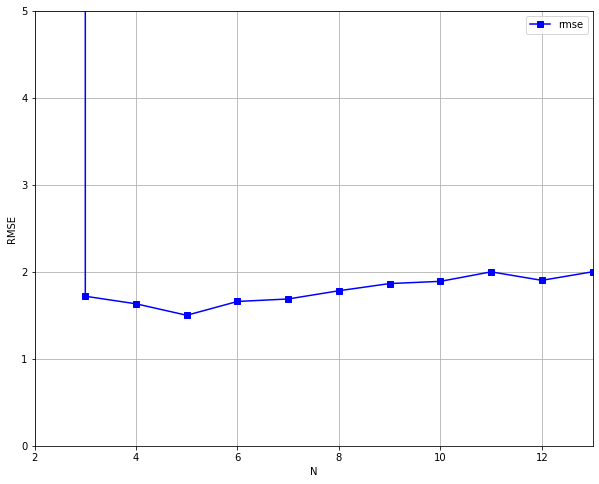

In [245]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = error_rate.plot(x=param_label, y='rmse', style='bs-', grid=True)

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
ax.set_ylim([0, 5])
matplotlib.rcParams.update({'font.size': 14})

In [246]:
# Get optimum value for param, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
N_opt

min RMSE = 1.501
optimum params = 


5

In [247]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
N_opt = temp['N'].values[0]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
N_opt

min MAPE = 1.038%
optimum params = 


5

## Tuning n_estimators (default=100) and max_depth (default=3)

In [248]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=param,
                                                              max_depth=param2,
                                                              learning_rate=learning_rate,
                                                              min_child_weight=min_child_weight,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 11.66


,n_estimators,max_depth,rmse,mape,mae
0,10,2,1.544574,1.069167,1.313073
1,10,3,1.559972,1.084240,1.330708
2,10,4,1.552405,1.078822,1.323689
3,10,5,1.536621,1.066801,1.308425
4,10,6,1.557146,1.084735,1.330161
5,10,7,1.557778,1.082676,1.328062
6,10,8,1.536247,1.070252,1.311963
7,10,9,1.591151,1.110210,1.360007
8,20,2,1.531850,1.062512,1.304472
9,20,3,1.546489,1.078853,1.323118


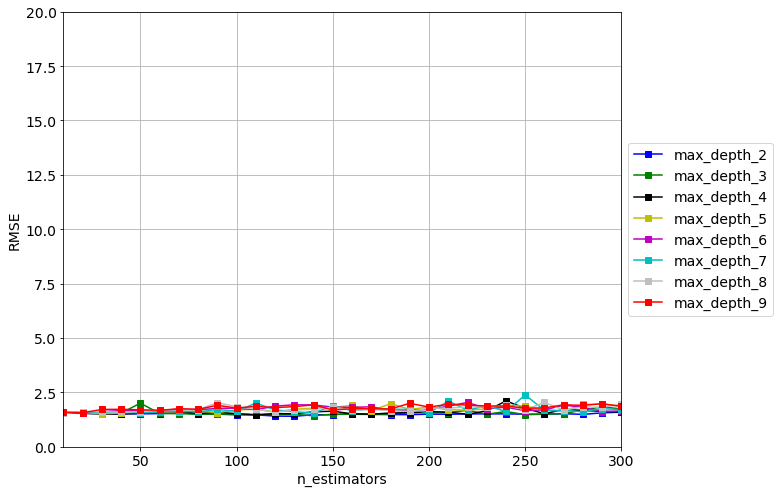

In [249]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [250]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 1.397
optimum params = 


(130, 2)

In [251]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 0.955%
optimum params = 


(130, 2)

## Tuning learning_rate(default=0.1) and min_child_weight(default=1)

In [252]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=param,
                                                              min_child_weight=param2,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 1.98


,learning_rate,min_child_weight,rmse,mape,mae
0,0.001,5,1.555945,1.071572,1.316903
1,0.001,6,1.555945,1.071572,1.316903
2,0.001,7,1.555945,1.071572,1.316903
3,0.001,8,1.555945,1.071572,1.316903
4,0.001,9,1.555945,1.071572,1.316903
5,0.001,10,1.555945,1.071572,1.316903
6,0.001,11,1.555945,1.071572,1.316903
7,0.001,12,1.555949,1.071577,1.316910
8,0.001,13,1.555949,1.071577,1.316910
9,0.001,14,1.556113,1.071747,1.317120


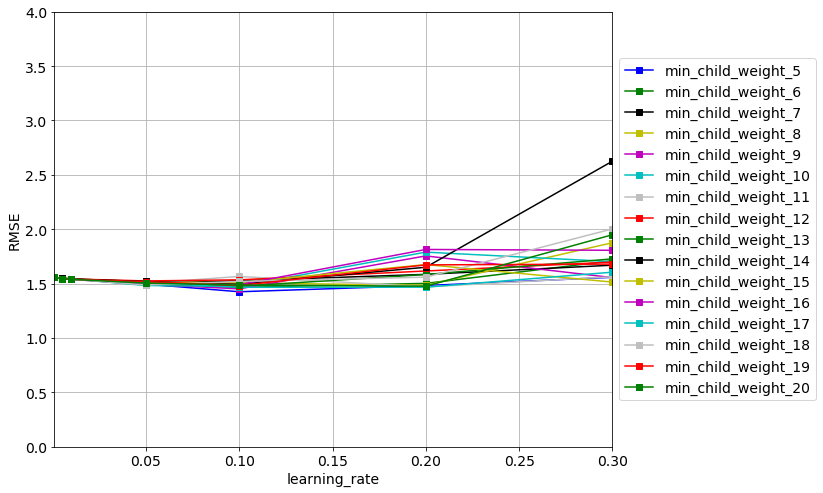

In [253]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
ax.set_ylim([0, 4])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [254]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 1.425
optimum params = 


(0.1, 5)

In [255]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 0.988%
optimum params = 


(0.1, 5)

## Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [256]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=param,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 1.80


,subsample,gamma,rmse,mape,mae
0,0.1,0.0,1.692855,1.153540,1.406537
1,0.1,0.1,1.692784,1.153513,1.406504
2,0.1,0.2,1.697683,1.156490,1.410460
3,0.1,0.3,1.587401,1.099238,1.342969
4,0.1,0.4,1.594115,1.103478,1.348214
5,0.1,0.5,1.593521,1.103014,1.347641
6,0.1,0.6,1.608288,1.117574,1.365814
7,0.1,0.7,1.608288,1.117574,1.365814
8,0.1,0.8,1.541639,1.069935,1.306768
9,0.1,0.9,1.548579,1.075182,1.312637


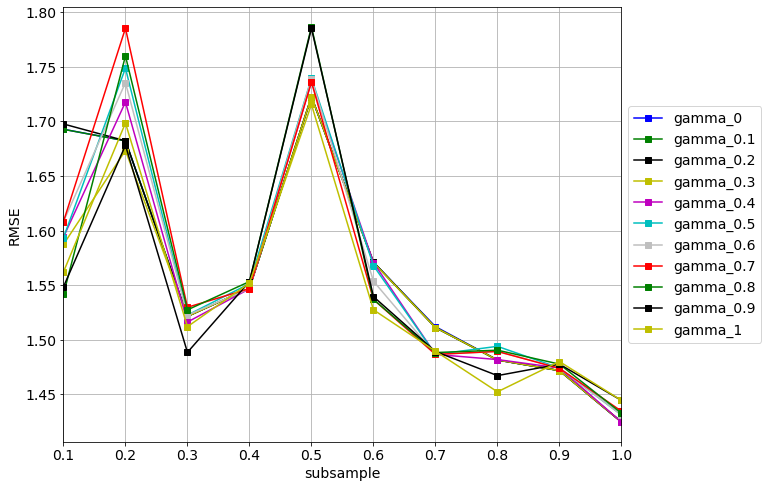

In [257]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [258]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 1.425
optimum params = 


(1.0, 0.0)

In [259]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 0.988%
optimum params = 


(1.0, 0.0)

## Tuning colsample_bytree(default=1) and colsample_bylevel(default=1)

In [260]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):    
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=subsample_opt,
                                                              colsample_bytree=param,
                                                              colsample_bylevel=param2,
                                                              gamma=gamma_opt)

    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 0.50


,colsample_bytree,colsample_bylevel,rmse,mape,mae
0,0.5,0.5,1.471880,1.023631,1.254062
1,0.5,0.6,1.471880,1.023631,1.254062
2,0.5,0.7,1.471880,1.023631,1.254062
3,0.5,0.8,1.471880,1.023631,1.254062
4,0.5,0.9,1.471880,1.023631,1.254062
5,0.5,1.0,1.510448,1.053310,1.293056
6,0.6,0.5,1.488545,1.034676,1.268747
7,0.6,0.6,1.488545,1.034676,1.268747
8,0.6,0.7,1.535081,1.066861,1.307447
9,0.6,0.8,1.535081,1.066861,1.307447


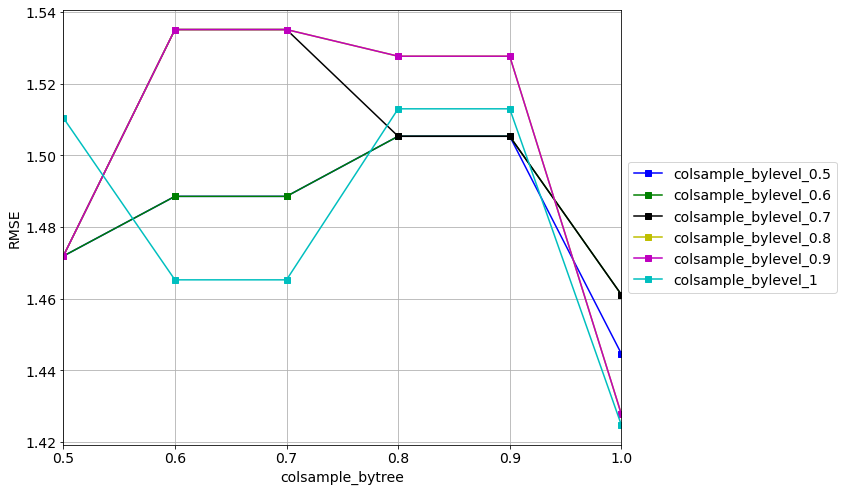

In [261]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [262]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 1.425
optimum params = 


(1.0, 1.0)

In [263]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 0.988%
optimum params = 


(1.0, 1.0)

## Final model

In [264]:
# Get error metrics on validation set after hyperparameter tuning
rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning, preds_dict = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        N_opt,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,
                                                                        learning_rate=learning_rate_opt,
                                                                        min_child_weight=min_child_weight_opt,
                                                                        subsample=subsample_opt,
                                                                        colsample_bytree=colsample_bytree_opt,
                                                                        colsample_bylevel=colsample_bylevel_opt,
                                                                        gamma=gamma_opt)
print("RMSE = %0.3f" % rmse_aft_tuning)
print("MAPE = %0.3f%%" % mape_aft_tuning)
print("MAE = %0.3f" % mae_aft_tuning)

RMSE = 1.425
MAPE = 0.988%
MAE = 1.211


In [265]:
# Plot validation predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))

# Plot the predictions
n = 0
for key in preds_dict:
    fig.add_trace(go.Scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(title='Without scaling',
                  yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [266]:
# Do prediction on test set
test_rmse_aft_tuning, test_mape_aft_tuning, test_mae_aft_tuning, est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       N_opt,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators_opt,
                                                                       max_depth=max_depth_opt,
                                                                       learning_rate=learning_rate_opt,
                                                                       min_child_weight=min_child_weight_opt,
                                                                       subsample=subsample_opt,
                                                                       colsample_bytree=colsample_bytree_opt,
                                                                       colsample_bylevel=colsample_bylevel_opt,
                                                                       gamma=gamma_opt)


print("RMSE = %0.3f" % test_rmse_aft_tuning)
print("MAPE = %0.3f%%" % test_mape_aft_tuning)
print("MAE = %0.3f" % test_mae_aft_tuning)

RMSE = 5.609
MAPE = 3.702%
MAE = 5.230


In [267]:
# Plot test predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=train['date'], 
                         y=train['adj_close'],
                         mode='lines',
                         name='train',
                         line=dict(color='blue')))
fig.add_trace(go.Scatter(x=val['date'], 
                         y=val['adj_close'],
                         mode='lines',
                         name='validation',
                         line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test['date'], 
                         y=test['adj_close'],
                         mode='lines',
                         name='test',
                         line=dict(color='green')))
fig.add_trace(go.Scatter(x=test[:H]['date'], 
                         y=est,
                         mode='lines',
                         name='predictions',
                         line=dict(color='red')))
fig.update_layout(title='Without scaling',
                  yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))

In [268]:
feature_importances, features, N_opt

(array([0.48566648, 0.15908457, 0.0951241 , 0.12629443, 0.13383046],
       dtype=float32),
 ['adj_close_scaled_lag_1',
  'adj_close_scaled_lag_2',
  'adj_close_scaled_lag_3',
  'adj_close_scaled_lag_4',
  'adj_close_scaled_lag_5'],
 5)

In [269]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('adj_close_scaled_lag_3', 0.095124096),
 ('adj_close_scaled_lag_4', 0.12629443),
 ('adj_close_scaled_lag_5', 0.13383046),
 ('adj_close_scaled_lag_2', 0.15908457),
 ('adj_close_scaled_lag_1', 0.48566648)]

## Tuned params

In [270]:
# Tuned params and before and after error metrics
d = {'param': ['N', 'n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'val_rmse', 'val_mape', 'val_mae'],
     'before_tuning': [N, n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning],
     'after_tuning': [N_opt, n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,before_tuning,after_tuning
0,N,3.000,5.000
1,n_estimators,100.000,130.000
2,max_depth,3.000,2.000
3,learning_rate,0.100,0.100
4,min_child_weight,1.000,5.000
5,subsample,1.000,1.000
6,colsample_bytree,1.000,1.000
7,colsample_bylevel,1.000,1.000
8,gamma,0.000,0.000
9,val_rmse,1.719,1.425


# Findings

In [271]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'], H))

Predicting on day 1260, date 2018-01-03 00:00:00, with forecast horizon H = 21


In [272]:
rmse_bef_tuning, rmse_aft_tuning

(1.7194927422409176, 1.4247882315680716)

In [273]:
test_rmse_bef_tuning, test_rmse_aft_tuning

(5.324588861915739, 5.609007157570267)

In [274]:
results = pd.DataFrame({'day': ['2017-01-03', 
                                     '2017-03-06', 
                                     '2017-05-04', 
                                     '2017-07-05', 
                                     '2017-09-01',
                                     '2017-11-01',
                                     '2018-01-03',
                                     '2018-03-06',
                                     '2018-05-04', 
                                     '2018-07-05',
                                     '2018-09-04',
                                     '2018-11-01'],
                             'val_rmse_bef_tuning': [2.427, 1.921, 2.201, 41.213, 3.065, 3.887, 1.719, 5.598, 15.743, 2.685, 9.069, 3.370], 
                             'val_rmse_aft_tuning': [2.071, 1.690, 1.836, 1.508, 1.350, 1.510, 1.425, 2.183, 2.112, 2.380, 2.824, 3.279],
                             'test_rmse_bef_tuning': [1.446, 1.558, 0.972, 1.718, 1.724, 1.239, 5.325, 3.892, 6.507, 3.854, 1.049, 2.606],
                             'test_rmse_aft_tuning': [1.417, 1.647, 0.945, 1.660, 1.880, 1.507, 5.609, 3.731, 4.622, 4.529, 0.7055, 2.545]})
results

,day,val_rmse_bef_tuning,val_rmse_aft_tuning,test_rmse_bef_tuning,test_rmse_aft_tuning
0,2017-01-03,2.427,2.071,1.446,1.4170
1,2017-03-06,1.921,1.690,1.558,1.6470
2,2017-05-04,2.201,1.836,0.972,0.9450
3,2017-07-05,41.213,1.508,1.718,1.6600
4,2017-09-01,3.065,1.350,1.724,1.8800
5,2017-11-01,3.887,1.510,1.239,1.5070
6,2018-01-03,1.719,1.425,5.325,5.6090
7,2018-03-06,5.598,2.183,3.892,3.7310
8,2018-05-04,15.743,2.112,6.507,4.6220
9,2018-07-05,2.685,2.380,3.854,4.5290


In [275]:
results.mean()

val_rmse_bef_tuning     7.741500
val_rmse_aft_tuning     2.014000
test_rmse_bef_tuning    2.657500
test_rmse_aft_tuning    2.566458
dtype: float64